# Calibration and example generation

Let's now calibrate our classifier to work out the actual probabilities of them containing a work of art, and generate probable examples for NER.

In [1]:
%cd ..

/home/bookfinder


Load in the calibration data

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np

In [3]:
dir_annotations = Path('data/00_annotations/03_book_binary/')

path = dir_annotations/'hnbook_binary_calibrate.jsonl'

In [4]:
df = pd.read_json(path, lines=True)

In [5]:
df = pd.concat([df, df.meta.apply(pd.Series)], axis=1)

In [6]:
df.answer.value_counts()

reject    177
accept     18
ignore      5
Name: answer, dtype: int64

Drop the ignores so we only have accept/reject

In [7]:
df['binary'] = df['answer'] == 'accept'
df.loc[df.answer=='ignore', 'binary'] = np.nan

df.binary.value_counts()

False    177
True      18
Name: binary, dtype: int64

Let's estimate the true probability $p$ based on the calibration data, against the predicted probability

In [8]:
calib_prob = (
    df
    .groupby('prob_group')
    .agg(p=('binary', 'mean'),
         n=('binary', 'count'),
         p_pred=('prob', 'mean'))
)
calib_prob

,p,n,p_pred
prob_group,,,
0.0,0.000000,20,0.053331
1.0,0.000000,20,0.132791
2.0,0.050000,20,0.241222
3.0,0.105263,19,0.336504
4.0,0.050000,20,0.443482
5.0,0.105263,19,0.542699
6.0,0.000000,20,0.646291
7.0,0.200000,20,0.758897
8.0,0.111111,18,0.851050


There is a low probability for <70%, and an increasing probability for >70%

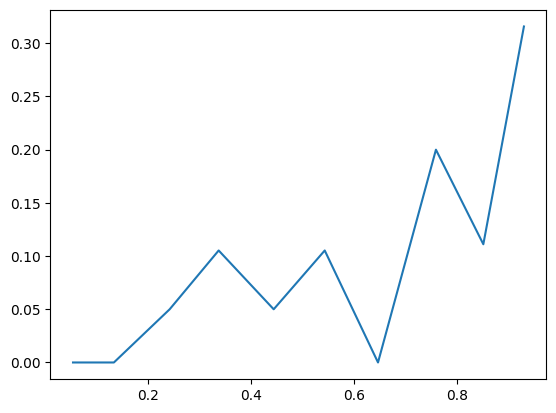

In [9]:
import matplotlib.pyplot as plt

plt.plot(calib_prob.p_pred, calib_prob.p)

Looking into the examples the higher probability ones are more likely to be

In [10]:
pd.options.display.max_colwidth = 1000
df.loc[df.binary==1].sort_values('prob')[['text', 'prob']]

,text,prob
116,One of my favourite parts of Blade Runner 2048 is where they show the insect farms.\n\nCould you imagine the total cost of replacing biological systems with man-made ones? We are playing with fire.,0.219741
142,"> After some reflection, I've removed this Easter egg. It'll be gone in the upcoming man-db 2.8.0.\n\nOh well, it was quite funny while it lasted. I like to imagine a person searching ""man gimme gimme gimme after midnight"" and being, for lack of a better word, rickrolled with that ABBA song.",0.301379
117,">Many video games have very poor or bare plots, but amazing settings.\n\nCyberpunk 2077 is also a great example of this trope. Night City itself is magnificent, and the missions aren't half bad either, but the main storyline is tiresome and has no satisfactory outcome. It feels as if they tried to have a deep plot but ended up botching it.",0.334751
198,">I’m going to get skewered for saying this … but the story feels like it’s pandering to current social political trends - i.e. the obsession with diversity\n\nHow so? I didn't get that feeling at all from Horizon Zero Dawn.\n\nIf someone told me HZD had an obsession with diversity I'd react with a standard ""wat?"". I do agree that some of the forced diversity in modern stories is annoying, mind you. I just didn't get that vibe from that one story.",0.418401
143,"I think that's correct with some overlap, yes. Zig's explicit goal - as stated by the creator - is to replace C. Nothing more, nothing less.\n\nI feel like Rust wants to replace C but it also wants to replace C++. And given the complexity difference between the two languages, that means that Rust will end up closer to C++ than to C.\n\nSo there's some overlap based on how Rust positions itself, but not based on how Zig positions itself.",0.537823
140,"For someone like me who doesn't really like the passive experience of movies/TV, story-heavy games are a good thing. What Remains of Edith Finch is one of my favorite games of all time.",0.577584
153,"I would personally classify interactive fiction closer to games, unless you count gamebooks in that, which I consider closer to books. There was also a movie where you get to get choices linked to Black Mirror that was popular recently, and a few people on youtube explored this by making different videos and letting you pick ""what happens next"".\n\nThere's also the whole genre of visual novels, mostly from Japan. I'm not sure if they are more games, books or interactive fiction.",0.713569
191,"People still play HoMM 3 from 1999 - both as a hobby in large numbers, and professionally. New content is being created.\n\nMaster of Magic gets a new life with bugfix/balance patches and addons. It's from 1993.",0.738065
115,"I'll leave a differing opinion on Earth. It was the least favourite book that I've read last decade. Felt like some childish revenge fantasy to me. It's been many years now, and I'm still annoyed by it.",0.759348
123,"If you go one level meta, it's not hard to imagine a Ken Thompson ""Reflections on Trusting Trust"" situation where that DNA codes for some brain malware that will inject more malware whenever its host is at work writing software, such as for a DNA sequencer.\n\nhttps://users.ece.cmu.edu/~ganger/712.fall02/papers/p761-thompson.pdf",0.772017


# Export examples for annotation

## Confirmed examples

In [11]:
annotation_files = list(Path('data/00_annotations/03_book_binary/').glob('*.jsonl'))

In [12]:
df_annotated = pd.concat([pd.read_json(f, lines=True) for f in annotation_files])

df_annotated

,text,meta,_input_hash,_task_hash,label,_view_id,answer,_timestamp
0,"Edgar Dijkstra's 1988 Paper ""On the Cruelty of Really Teaching Computer Science""\n\nIt's just a paper, but still I'd recommend it, because it was highly influential. It was indeed so influential that it has its own Wikipedia page: https://en.wikipedia.org/wiki/On_the_Cruelty_of_Really_Teaching_Computer_Science\n\nIn the paper he argues that\n\n- the computer industy has been progressing with exponential growth 1948-1988,\n\n- will continue to do so for decades (he was right in that)\n\n- this rate of progress is unprecedented, and the human brain is unfit to deal with such growth, thus\n\n- the only way to deal with such enormous mount of power is: Mathematics, because proofs are rigorous. (I'm simplifying a bit here.)",{'id': 29315827},1785041567,1383587949,WORK_OF_ART,classification,accept,1668086341
1,"I've been struck by how ugly some stores catering to the poor are. Not ugly because they are cheaply decorated, but intentionally ugly, using things like black on yellow coloring for signage, etc. I guess it's eye-catching, but not in a good way.",{'id': 27651856},1647574332,-771474339,WORK_OF_ART,classification,reject,1668086345
2,I completely misread the title as most nerd-friendly toilet. Like those high tech japanese models with tons of functions...,{'id': 26530597},-895080820,264616600,WORK_OF_ART,classification,reject,1668086347
3,"Scihub has been a life saver for me once I started working on some of the more obscure areas of AI such as signal/time series processing. Anything off the beaten path is locked up behind paywalls, and I'm sorry I ain't paying $40 just to see if someone's paper sucks or not (which 95% of them do, in this particular niche, especially the ones shielded from scrutiny by paywalls).",{'id': 29009317},2092742992,888756534,WORK_OF_ART,classification,reject,1668086352
4,I came across them on TikTok. Seems like a pretty nice and actually well thought out idea. Will be interesting to see if they are able to make something successful out of it.\n\nAlso apparently they are going to run a fundraiser on Kickstarter in January 2022.,{'id': 29173898},-1998768893,1612341585,WORK_OF_ART,classification,reject,1668086356
...,...,...,...,...,...,...,...,...
195,Sounds like you might be interested in the IndieWeb project: https://indieweb.org/,"{'id': 25741321, 'prob_group': 1, 'prob': 0.1649630152}",1533184239,1978233275,WORK_OF_ART,classification,reject,1668833525
196,"Fair criticism. I'm the author, and I hate using interfaces like this, but didn't comment on it probably because I got used to it for this kind of thing.\n\nThe only reason why I defined inventory.DB (https://github.com/henvic/pgxtutorial/blob/main/internal/inventory/service.go#L18-L50) is to be able to test. Otherwise, I'd have skipped it.\n\nI haven't read your article yet, but will do so later and get back to this subject and tell my opinion by the end of the day (on vacation, and need to hurry to catch the train!).","{'id': 29315060, 'prob_group': 3, 'prob': 0.3636388236}",1031708670,377284503,WORK_OF_ART,classification,reject,1668833534
197,"It's highly relevant from a perspective of philosophical and scientific curiosity, and mostly (seemingly) irrelevant from a perspective of practical impact on our lives.\n\nI'm also cautious to jump to such conclusions given how nascent we are technologically, even though the light speed barrier does seem absolute. Our recent ancestors probably would've thought a similar thing about life orbiting a nearby star, and it's only with the hindsight of recent advances that we're able to conclude that that's not as far out of our reach as once believed. Who knows what one million years of additional technological advances will make us capable of?","{'id': 26074398, 'prob_group': 4, 'prob': 0.44821304910000004}",1215479405,776996849,WORK_OF_ART,classification,reject,1668833538
198,">I’m going to get skewered for saying this … but the story fee

Many of the texts contain a reference such as `[1]` directly after a title.

This sometimes causes issues with the tokenizer in SpaCy/Prodigy making it impossible to correctly annotate, so we'll add an extra space.

In [13]:
df_annotated[df_annotated['text'].str.match(r'.*([^] ])(\[\d+\]\W)')].text

34                                                                                                                                                                                                                                                                                                                                                                                                                                               A lot of this is described in the book ‘The Age of Surveillance Capitalism’ by author Professor Shoshana Zuboff[1]. There’s also a good documentary on Netflix (I forget which, I think it’s ‘The Great Hack’[2]), explaining how the ‘Cambridge Analytica’ scandal utilised personal data and more importantly behaviour.\n\nThey’re just scarily good at predicting what you are going to do. They’re not listening in. It’s far scarier/more insidious than that.\n\n[1] https://en.wikipedia.org/wiki/The_Age_of_Surveillance_Capitalism\n\n[2] https://www.netflix.com/gb/title/80

In [14]:
df_annotated['text'] = df_annotated['text'].str.replace(r'([^] ])(\[\d+\]\W)', r'\1 \2', regex=True)

In [15]:
df_out = df_annotated.query('answer=="accept"').sample(frac=1)

df_out

,text,meta,_input_hash,_task_hash,label,_view_id,answer,_timestamp
70,"Funny you mention that story, I came across it for the first time about 3 days ago in a book I was reading -- Grammatical Man. It's one of the best reads I've found on the history of information theory. Funnily enough the friend that lent it to me isn't even a tech person, he's an electrician who's more interested in occultism and esotericism than mathematics and technology.\n\nEvery time I read about the 20th century history of computing, it sounds like it was a wild time. Every advance or discovery seems to have some humorous anecdote attached to it.",{'id': 26725071},1314777974,-512151247,WORK_OF_ART,classification,accept,1668086764
28,"I can’t tell you what is that website, but the concept of broken window reminds me a book that talked about it:\n\nhttps://www.amazon.fr/Pragmatic-Programmer-Journeyman-Master/dp/020161622X\n\n(No affiliation)",{'id': 28902849},1240344239,-1388700312,WORK_OF_ART,classification,accept,1668086513
143,"I think that's correct with some overlap, yes. Zig's explicit goal - as stated by the creator - is to replace C. Nothing more, nothing less.\n\nI feel like Rust wants to replace C but it also wants to replace C++. And given the complexity difference between the two languages, that means that Rust will end up closer to C++ than to C.\n\nSo there's some overlap based on how Rust positions itself, but not based on how Zig positions itself.","{'id': 28460092, 'prob_group': 5, 'prob': 0.5378234163}",632698448,1381416523,WORK_OF_ART,classification,accept,1668833179
116,One of my favourite parts of Blade Runner 2048 is where they show the insect farms.\n\nCould you imagine the total cost of replacing biological systems with man-made ones? We are playing with fire.,"{'id': 26770161, 'prob_group': 2, 'prob': 0.2197414097}",1842475650,-357462958,WORK_OF_ART,classification,accept,1668832907
0,"Edgar Dijkstra's 1988 Paper ""On the Cruelty of Really Teaching Computer Science""\n\nIt's just a paper, but still I'd recommend it, because it was highly influential. It was indeed so influential that it has its own Wikipedia page: https://en.wikipedia.org/wiki/On_the_Cruelty_of_Really_Teaching_Computer_Science\n\nIn the paper he argues that\n\n- the computer industy has been progressing with exponential growth 1948-1988,\n\n- will continue to do so for decades (he was right in that)\n\n- this rate of progress is unprecedented, and the human brain is unfit to deal with such growth, thus\n\n- the only way to deal with such enormous mount of power is: Mathematics, because proofs are rigorous. (I'm simplifying a bit here.)",{'id': 29315827},1785041567,1383587949,WORK_OF_ART,classification,accept,1668086341
...,...,...,...,...,...,...,...,...
59,"Thanks for the link.\n\nYou also say ""January 6, 1614"". Very specific again! Where did you get that from? There are no dates that I can see, nevermind the 6th of January.\n\nDid you read the cover page? Not where it confirms that the book is a reproduction of another book held at Chatworth House. Ie not an original.\n\nI mean the bit where it says: ""By the Gentlemen of Graies-Inne, at the Court of White-hall, in the Banquercing House, vpon Twelfe night, 1613.""\n\nHere's a link:\nhttps://www.google.com/books/edition/The_Maske_of_Flowers/qCQ_AQAAMAAJ?hl=en&gbpv=1&bsq=1613\n\nThis says to me that the book although published (perhaps) in 1614 relates to a time in 1613.\n\nWhenever I look into this stuff, I get more uncomfortable.",{'id': 26507628},-789806029,-1144587893,WORK_OF_ART,classification,accept,1668549577
107,"It's funny to see SimCity 2000 coming true. Hopefully not the disaster part, though.\n\nhttps://simcity.fandom.com/wiki/Microwave_Power_Plant\n\nhttps://simcity.fandom.com/wiki/Microwave_(disaster)\n\nhttps://www.deviantart.com/canona2200/art/SIMCITY-2000-Microwave-Power-Plant-439236836",{'id': 26675724},-1883215776,297058536,WORK_OF_ART,classification,accept,1668829840
21,"I don't know if you 

In [16]:
import json

with open('data/02_intermediate/hn_sample_ner_confirmed.jsonl', 'w') as f:
    for id, row in df_out.iterrows():
        data = {"text": row["text"], "meta": {"id": row["meta"]["id"]}}
        print(json.dumps(data), file=f)

In [17]:
pd.read_json('data/02_intermediate/hn_sample_ner_confirmed.jsonl', lines=True)

,text,meta
0,"Funny you mention that story, I came across it for the first time about 3 days ago in a book I was reading -- Grammatical Man. It's one of the best reads I've found on the history of information theory. Funnily enough the friend that lent it to me isn't even a tech person, he's an electrician who's more interested in occultism and esotericism than mathematics and technology.\n\nEvery time I read about the 20th century history of computing, it sounds like it was a wild time. Every advance or discovery seems to have some humorous anecdote attached to it.",{'id': 26725071}
1,"I can’t tell you what is that website, but the concept of broken window reminds me a book that talked about it:\n\nhttps://www.amazon.fr/Pragmatic-Programmer-Journeyman-Master/dp/020161622X\n\n(No affiliation)",{'id': 28902849}
2,"I think that's correct with some overlap, yes. Zig's explicit goal - as stated by the creator - is to replace C. Nothing more, nothing less.\n\nI feel like Rust wants to replace C but it also wants to replace C++. And given the complexity difference between the two languages, that means that Rust will end up closer to C++ than to C.\n\nSo there's some overlap based on how Rust positions itself, but not based on how Zig positions itself.",{'id': 28460092}
3,One of my favourite parts of Blade Runner 2048 is where they show the insect farms.\n\nCould you imagine the total cost of replacing biological systems with man-made ones? We are playing with fire.,{'id': 26770161}
4,"Edgar Dijkstra's 1988 Paper ""On the Cruelty of Really Teaching Computer Science""\n\nIt's just a paper, but still I'd recommend it, because it was highly influential. It was indeed so influential that it has its own Wikipedia page: https://en.wikipedia.org/wiki/On_the_Cruelty_of_Really_Teaching_Computer_Science\n\nIn the paper he argues that\n\n- the computer industy has been progressing with exponential growth 1948-1988,\n\n- will continue to do so for decades (he was right in that)\n\n- this rate of progress is unprecedented, and the human brain is unfit to deal with such growth, thus\n\n- the only way to deal with such enormous mount of power is: Mathematics, because proofs are rigorous. (I'm simplifying a bit here.)",{'id': 29315827}
...,...,...
73,"Thanks for the link.\n\nYou also say ""January 6, 1614"". Very specific again! Where did you get that from? There are no dates that I can see, nevermind the 6th of January.\n\nDid you read the cover page? Not where it confirms that the book is a reproduction of another book held at Chatworth House. Ie not an original.\n\nI mean the bit where it says: ""By the Gentlemen of Graies-Inne, at the Court of White-hall, in the Banquercing House, vpon Twelfe night, 1613.""\n\nHere's a link:\nhttps://www.google.com/books/edition/The_Maske_of_Flowers/qCQ_AQAAMAAJ?hl=en&gbpv=1&bsq=1613\n\nThis says to me that the book although published (perhaps) in 1614 relates to a time in 1613.\n\nWhenever I look into this stuff, I get more uncomfortable.",{'id': 26507628}
74,"It's funny to see SimCity 2000 coming true. Hopefully not the disaster part, though.\n\nhttps://simcity.fandom.com/wiki/Microwave_Power_Plant\n\nhttps://simcity.fandom.com/wiki/Microwave_(disaster)\n\nhttps://www.deviantart.com/canona2200/art/SIMCITY-2000-Microwave-Power-Plant-439236836",{'id': 26675724}
75,"I don't know if you would take this as a neutral resource, but if you are interested in this subject, you may find the writings of Henry Morgenthau Sr. interesting. He was the U.S. Ambassador to the Ottoman Empire during the period when the USA was neutral in WWI. He also happened to be a friend of my great-grandfather.\n\nIn particular I would recommend ""I was sent to Athens"" (link: https://openlibrary.org/books/OL6734490M/I_was_sent_to_Athens) and the section on the 1922 Izmir Fire.",{'id': 26925644}
76,"For anyone interested in learning more about the ANSI art scene and BBS history in general, I highly recommend Jason Scott's documentary series "

## Probable examples

In [18]:
df = (
    pd.read_parquet('data/02_intermediate/hn_enriched.parquet')
    .query('bucket<=3 & text_length > 0')
)

len(df)

142339

As before insert an extra space in references

In [19]:
df['clean_text'] = df['clean_text'].str.replace(r'([^] ])(\[\d+\]\W)', r'\1 \2', regex=True)

Calculate probability with model

In [20]:
text = df.clean_text.to_list()

In [21]:
from setfit import SetFitModel

In [22]:
model = SetFitModel.from_pretrained('data/06_models/setfit_2')

In [23]:
%%time
probs = model.predict_proba(text)[:,0]

CPU times: user 3min 12s, sys: 17.2 s, total: 3min 29s
Wall time: 1min 52s


In [24]:
df['prob'] = probs

Filter to examples with a model probability > 90% (which corresponds to an actual probability of ~30%).

In [25]:
df_out = df.query('prob > 0.9').sample(frac=1)

df_out

,title,url,text,dead,by,score,time,timestamp,type,parent,descendants,ranking,deleted,root,clean_text,bucket,text_length,prob
id,,,,,,,,,,,,,,,,,,
27470971,None,None,I can only recommend book by Matthew Walker &#x27;Why we sleep - The new science of sleep and dreams&#x27;,None,me_me_me,NaN,1623403017,2021-06-11 09:16:57+00:00,comment,27470859,NaN,NaN,None,27458974,I can only recommend book by Matthew Walker 'Why we sleep - The new science of sleep and dreams',2,96,0.951312
28204781,None,None,"I would personally recommend Good Reasons for Bad Feelings\nBy Randolph M. Nesse<p>The author digs into the idea that humans may have evolved to a certain extent to have good reasons for bad feelings. Several fascinating cases are cited and it made me realise how feelings can be a warning of something. Maybe a bit like when we eat too much salt or sweet then the body reacts. Emotions could work like that but perhaps in a less tangible way.<p><a href=""https:&#x2F;&#x2F;www.penguinrandomhouse.com&#x2F;books&#x2F;546633&#x2F;good-reasons-for-bad-feelings-by-randolph-m-nesse-md&#x2F;"" rel=""nofollow"">https:&#x2F;&#x2F;www.penguinrandomhouse.com&#x2F;books&#x2F;546633&#x2F;good-reasons...</a>",None,koilke,NaN,1629161055,2021-08-17 00:44:15+00:00,comment,28201711,NaN,NaN,None,28200727,I would personally recommend Good Reasons for Bad Feelings\nBy Randolph M. Nesse\n\nThe author digs into the idea that humans may have evolved to a certain extent to have good reasons for bad feelings. Several fascinating cases are cited and it made me realise how feelings can be a warning of something. Maybe a bit like when we eat too much salt or sweet then the body reacts. Emotions could work like that but perhaps in a less tangible way.\n\nhttps://www.penguinrandomhouse.com/books/546633/good-reasons-for-bad-feelings-by-randolph-m-nesse-md/,3,544,0.955778
26753531,None,None,"As someone whose great uncles worked in the steel factories nearby, whose parents before that labored in the cotton fields, I can also testify the multi-century efforts of Black workers who fought the “hands that was fedding them”. America&#x27;s Johannesburg [1] and Hammer and Hoe [2] for reference.<p>[1] <a href=""https:&#x2F;&#x2F;ugapress.org&#x2F;book&#x2F;9780820356273&#x2F;americas-johannesburg&#x2F;"" rel=""nofollow"">https:&#x2F;&#x2F;ugapress.org&#x2F;book&#x2F;9780820356273&#x2F;americas-johannesbur...</a><p>[2] <a href=""https:&#x2F;&#x2F;uncpress.org&#x2F;book&#x2F;9781469625485&#x2F;hammer-and-hoe&#x2F;"" rel=""nofollow"">https:&#x2F;&#x2F;uncpress.org&#x2F;book&#x2F;9781469625485&#x2F;hammer-and-hoe&#x2F;</a>",None,charlescearl,NaN,1617989941,2021-04-09 17:39:01+00:00,comment,26752316,NaN,NaN,None,26751562,"As someone whose great uncles worked in the steel factories nearby, whose parents before that labored in the cotton fields, I can also testify the multi-century efforts of Black workers who fought the “hands that was fedding them”. America's Johannesburg [1] and Hammer and Hoe [2] for reference.\n\n [1] https://ugapress.org/book/9780820356273/americas-johannesburg/\n\n [2] https://uncpress.org/book/9781469625485/hammer-and-hoe/",1,425,0.961454
25633283,None,None,This is a new 7-part documentary series by Veritasium and Seeker following the World Solar Challenge as they race across the Australian outback. Some really world-class college engineering teams building and racing experimental solar&#x2F;electric vehicles.,None,chrisdalke,NaN,1609777022,2021-01-04 16:17:02+00:00,comment,25633249,NaN,NaN,None,25633249,This is a new 7-part documentary series by Veritasium and Seeker following the World Solar Challenge as they race across the Australian outback. Some really world-class college engineering teams building and racing experimental solar/electric vehicles.,1,252,0.945693
25770856,None,None,"An incredible book indeed. I remember reading it initially out of curiosity to know who this historic figure was and after finishing feeling like my eyes were opened to the reality o

Remove already annotated examples

In [26]:
df_out = df_out[~df_out.index.isin(df_annotated.meta.apply(lambda x: x['id']))]

Save to disk

In [27]:
import json

with open('data/02_intermediate/hn_sample_ner_p90.jsonl', 'w') as f:
    for id, row in df_out.iterrows():
        data = {"text": row["clean_text"], "meta": {"id": id,
                                                    "prob": row.prob}}
        print(json.dumps(data), file=f)

In [28]:
pd.read_json('data/02_intermediate/hn_sample_ner_p90.jsonl', lines=True)

,text,meta
0,I can only recommend book by Matthew Walker 'Why we sleep - The new science of sleep and dreams',"{'id': 27470971, 'prob': 0.951312388313972}"
1,I would personally recommend Good Reasons for Bad Feelings\nBy Randolph M. Nesse\n\nThe author digs into the idea that humans may have evolved to a certain extent to have good reasons for bad feelings. Several fascinating cases are cited and it made me realise how feelings can be a warning of something. Maybe a bit like when we eat too much salt or sweet then the body reacts. Emotions could work like that but perhaps in a less tangible way.\n\nhttps://www.penguinrandomhouse.com/books/546633/good-reasons-for-bad-feelings-by-randolph-m-nesse-md/,"{'id': 28204781, 'prob': 0.9557777591738891}"
2,"As someone whose great uncles worked in the steel factories nearby, whose parents before that labored in the cotton fields, I can also testify the multi-century efforts of Black workers who fought the “hands that was fedding them”. America's Johannesburg [1] and Hammer and Hoe [2] for reference.\n\n [1] https://ugapress.org/book/9780820356273/americas-johannesburg/\n\n [2] https://uncpress.org/book/9781469625485/hammer-and-hoe/","{'id': 26753531, 'prob': 0.961454031045859}"
3,This is a new 7-part documentary series by Veritasium and Seeker following the World Solar Challenge as they race across the Australian outback. Some really world-class college engineering teams building and racing experimental solar/electric vehicles.,"{'id': 25633283, 'prob': 0.9456927516035261}"
4,"An incredible book indeed. I remember reading it initially out of curiosity to know who this historic figure was and after finishing feeling like my eyes were opened to the reality of the world around us. As a person of color who didn't think too much about racial justice previously, it woke me up to injustices that I did not notice before.\n\nI should read it again as well.","{'id': 25770856, 'prob': 0.9289292958913901}"
...,...,...
1176,"Written in short form and taken at face value, I can see why you may have this reaction to his writing. Read the sovereign individual, basically his thoughts in long form. Thiel even writes the pre-face to the book.\n\nHis main arguments are that politics divides, democracy favors the 51% at the expense of the 49%. He is for smaller government, less political divides, and the abandonment of the welfare state that creates a government dependent population with incredible waste. His ideas are not all that radical, considering debt spending by world governments is currently unsustainable.\n\nPeople are largely irrational & bias. The thing about morality is everyone thinks they have the answers leading the government to be this odd form of paternalism where seemingly simple statements like ""No drugs"" are taken to this extreme that lead to more societal harm than good.","{'id': 28717289, 'prob': 0.9358837277745391}"
1177,"I’m guessing more cetaceans will get on this list as we learn more about them. They might have a very dark humor after all the generational trauma we’ve added to their existence.\n\nFor more, ethologist (animal-behaviorist) Frans de Waal writes engaging books (primates), as does Patricia McConnell (dogs), Jennifer Ackerman (birds), and Bernd Heinrich (insects, birds), amongst many others. Any you suggest?","{'id': 27213622, 'prob': 0.9366106863245631}"
1178,"Space Debris absolutely blew me away when I first heard it on my brand new Mediavision Pro Audio Spectrum 16. :-)\n\nDid you ever hear the updated version by the original artist, Markus Kaarlonen? It's on the Rochard OST and is awesome too.\n\nhttps://youtu.be/bsapsOqc7UI","{'id': 26517342, 'prob': 0.9007357147648851}"
1179,"A detailed rebuttal to Krahe is presented by Wasson, p129. Note that you are basing your argument on Greek, but this is a preGreek term.\n\nhttps://books.google.com/books/about/The_Road_to_Eleusis.html?id=lZXpO_3szpsC","{'id': 29451299, 'prob': 0.9349342626911241}"


Now we can annotate using

```
python -m prodigy ner.correct hnbook_ner_confirmed \
          en_core_web_trf \
          data/02_intermediate/hn_sample_ner_confirmed.jsonl \
          --label WORK_OF_ART
```